In [ ]:
# === Block 1: RAM logger ===
from google.colab import drive
drive.mount('/content/drive')

%pip -q install rpy2
%load_ext rpy2.ipython

import os, signal, subprocess, time
from datetime import datetime

LOG_PATH = "/content/process_ram_usage.txt"
PID_PATH = "/content/ram_logger.pid"

# Kill any existing logger we started earlier
if os.path.exists(PID_PATH):
    try:
        with open(PID_PATH, "r") as f:
            old_pid = int(f.read().strip())
        os.kill(old_pid, signal.SIGTERM)
        print(f"Stopped previous RAM logger (PID {old_pid})")
    except Exception as e:
        print(f"Could not stop previous logger: {e}")
    finally:
        try: os.remove(PID_PATH)
        except: pass

# Fresh log file
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    print("Cleared existing RAM log file")

# Start a simple logger:
bash_script = r'''
set -e
while true; do
  {
    echo "---------------"
    echo "TS $(date -u +%Y-%m-%dT%H:%M:%SZ)"
    echo "SYSTEM_TOTAL $(free -b | awk '/^Mem:/{print $2}')"
    echo "SYSTEM_USED  $(free -b | awk '/^Mem:/{print $3}')"
    echo "SYSTEM_AVAILABLE $(free -b | awk '/^Mem:/{print $7}')"
    ps -eo pid,user,comm,rss --sort=-rss | head -20 | awk '{print "PROC",$1,$2,$3,$4}'
  } >> /content/process_ram_usage.txt
  sleep 10
done
'''

log_proc = subprocess.Popen(["bash", "-c", bash_script], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
with open(PID_PATH, "w") as f:
    f.write(str(log_proc.pid))

print("Background RAM logging started")
print(f"Log file: {LOG_PATH}")
print(f"Logger PID: {log_proc.pid}")
print("Stop later with: !kill -9 $(cat /content/ram_logger.pid)")
time.sleep(2)


In [ ]:
%%R
# === Block 2: R training/eval with timing (UTC) ===

suppressPackageStartupMessages({
  library(data.table)
  library(rpart)
})

# Force UTC for all timestamps we capture
Sys.setenv(TZ = "UTC")

data <- list()  # list(process, start, end)

log_start <- function(name) {
  idx <- length(data) + 1L
  data[[idx]] <<- list(process = name, start = as.POSIXct(Sys.time(), tz = "UTC"), end = as.POSIXct(NA))
  invisible(idx)
}
log_end <- function(idx) {
  data[[idx]]$end <<- as.POSIXct(Sys.time(), tz = "UTC")
  invisible(NULL)
}

as_timing_df <- function(x = data) {
  if (!length(x)) return(data.frame(process=character(), start=as.POSIXct(character()), end=as.POSIXct(character()), duration_secs=numeric()))
  df <- data.table::rbindlist(lapply(x, as.data.table), fill = TRUE)
  df[, duration_secs := as.numeric(difftime(end, start, units = "secs"))]
  as.data.frame(df)
}

# --- Paths & schema ---
base_path  <- "/content/drive/MyDrive/data"
train_path <- file.path(base_path, "df_train.csv")
test_path  <- file.path(base_path, "df_test.csv")

features <- c(
  "perishable","onpromotion","on_hol","month","is_weekend","day",
  "store_nbr","item_nbr","city","state","type","cluster","family","class"
)
target <- "unit_sales"

cat("=== Workflow start (UTC) ===\n")

# Load training
i_load_tr <- log_start("load_train")
stopifnot(file.exists(train_path))
cat("Loading training data...\n")
DT_train <- data.table::fread(train_path, showProgress = TRUE)
cat(sprintf("Training data loaded: %d rows, %d columns\n", nrow(DT_train), ncol(DT_train)))
log_end(i_load_tr)

# Load test
i_load_te <- log_start("load_test")
stopifnot(file.exists(test_path))
cat("Loading test data...\n")
DT_test <- data.table::fread(test_path, showProgress = TRUE)
cat(sprintf("Test data loaded: %d rows, %d columns\n", nrow(DT_test), ncol(DT_test)))
log_end(i_load_te)

# Preprocess
i_prep <- log_start("preprocess")
cat("Preprocessing...\n")
DT_train[[target]] <- as.numeric(DT_train[[target]])
miss_tr <- setdiff(features, names(DT_train))
miss_te <- setdiff(features, names(DT_test))
if (length(miss_tr)) stop("Train missing features: ", paste(miss_tr, collapse = ", "))
if (length(miss_te)) stop("Test missing features: ", paste(miss_te, collapse = ", "))
train_used <- DT_train[, c(features, target), with = FALSE]
log_end(i_prep)

# Train
i_train <- log_start("train_model")
cat("Training model...\n")
ctrl <- rpart.control(
  minsplit = 1000, minbucket = 25, cp = 0.001,
  maxdepth = 7, xval = 0, maxcompete = 0, maxsurrogate = 0, usesurrogate = 0
)
form <- as.formula(paste(target, "~", paste(features, collapse = " + ")))
set.seed(42)
t0 <- Sys.time()
model <- rpart(formula = form, data = train_used, method = "anova", control = ctrl, model = FALSE, x = FALSE, y = FALSE)
t1 <- Sys.time()
cat(sprintf("Model trained in %.1f sec\n", as.numeric(difftime(t1, t0, units = "secs"))))
log_end(i_train)

# Predict
i_pred <- log_start("predict")
cat("Predicting...\n")
pred <- predict(model, newdata = DT_test[, features, with = FALSE])
log_end(i_pred)

# Evaluate
i_eval <- log_start("evaluate")
cat("Evaluating...\n")
y_true  <- as.numeric(DT_test[[target]])
valid   <- !is.na(y_true) & !is.na(pred)
y_true  <- y_true[valid]; y_pred <- pred[valid]
mse  <- mean((y_true - y_pred)^2)
rmse <- sqrt(mse)
mae  <- mean(abs(y_true - y_pred))
sse  <- sum((y_true - y_pred)^2)
sst  <- sum((y_true - mean(y_true))^2)
r2   <- 1 - (sse / sst)
log_end(i_eval)

# Results (printed for manual note-taking)
cat("\n=== EVALUATION RESULTS ===\n")
cat(sprintf("MSE : %.2f\nRMSE: %.2f\nMAE : %.2f", mse, rmse, mae))

# cat("\n=== STEP TIMINGS (raw list) ===\n")
# print(data)
# cat("\n--- Pretty view ---\n")
# print(as_timing_df(data))
# cat("\n=== Workflow end ===\n")


In [ ]:
%%R
# === Block 3: Export timing to CSV ===
# Produces one row per (process, phase), where phase as {"start","end"}.
# Columns: process, phase, time

stopifnot(exists("data"))

to_rows <- function(step) {
  data.frame(
    process = c(step$process, step$process),
    phase   = c("start", "end"),
    time    = format(step$start, "%Y-%m-%dT%H:%M:%SZ", tz = "UTC")
                |> c(format(step$end,   "%Y-%m-%dT%H:%M:%SZ", tz = "UTC")),
    stringsAsFactors = FALSE
  )
}

save_df <- do.call(rbind, lapply(data, to_rows))

write.csv(save_df, file = "/content/data.csv", row.names = FALSE)
cat("Saved timing data to /content/data.csv (UTC, ISO-8601)\n")


In [ ]:
# === Block 4: RAM plots : actual and normalized time ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---- Inputs ----
TIMING_CSV = "/content/data.csv"                 # written by Block 3
LOG_PATH   = "/content/process_ram_usage.txt"    # written by Block 1

# ---- Output base (per-run folder) ----
RUNS_BASE = "/content/drive/MyDrive/runs"
os.makedirs(RUNS_BASE, exist_ok=True)

# ---- Fixed segment colors (blue, yellow, red) ----
COLOR_LOADING  = "#1f77b4"  # blue
COLOR_TRAINING = "#ffd700"  # yellow (gold)
COLOR_EVAL     = "#d62728"  # red

# ---- Segment layout for normalized plot ----
SEG_WIDTHS = {"loading": 0.30, "training": 0.50, "evaluate": 0.20}
SEG_ORDER = ["loading", "training", "evaluate"]
SEG_COLORS = {"loading": COLOR_LOADING, "training": COLOR_TRAINING, "evaluate": COLOR_EVAL}

# 1) Load workflow events (expects: process, phase, time)
events = pd.read_csv(TIMING_CSV)
events["time"] = pd.to_datetime(events["time"], utc=True)
first_start = events.loc[events["phase"] == "start", "time"].min()
if pd.isna(first_start):
    raise RuntimeError("No start event found in timing CSV.")

# Stable run_id per run
run_id = "run_" + first_start.strftime("%Y%m%dT%H%M%SZ")
run_dir = os.path.join(RUNS_BASE, run_id)
os.makedirs(run_dir, exist_ok=True)

# Milestones
markers = [{"label": "before_load", "time": first_start}]
label_map = {"load_test":"after_load_test", "train_model":"after_train", "evaluate":"after_eval"}
for proc, lab in label_map.items():
    row = events[(events["process"] == proc) & (events["phase"] == "end")]
    if not row.empty:
        markers.append({"label": lab, "time": pd.to_datetime(row.iloc[0]["time"], utc=True)})
markers_df = pd.DataFrame(markers).sort_values("time").reset_index(drop=True)

# 2) Parse RAM log (SYSTEM_USED bytes to GB)
def parse_ram_log(path=LOG_PATH):
    if not os.path.exists(path):
        raise FileNotFoundError(f"RAM log not found: {path}")
    ts = None
    rows = []
    with open(path, "r") as f:
        for line in f:
            s = line.strip()
            if s.startswith("TS "):
                ts = pd.to_datetime(s.split()[1], utc=True)
            elif s.startswith("SYSTEM_USED"):
                try:
                    used_bytes = int(s.split()[1])
                    if ts is not None:
                        rows.append({"time": ts, "ram_gb": used_bytes / (1024**3)})
                except Exception:
                    pass
    df = pd.DataFrame(rows).sort_values("time").reset_index(drop=True)
    if df.empty:
        raise RuntimeError("Parsed RAM log is empty. Has the logger run long enough?")
    return df

ram = parse_ram_log()
ram["time"] = pd.to_datetime(ram["time"], utc=True)

# 3) Align milestones to nearest sample at-or-before
markers_for_merge = markers_df.rename(columns={"time": "event_time"}).sort_values("event_time")
aligned_df = pd.merge_asof(
    markers_for_merge, ram.sort_values("time"),
    left_on="event_time", right_on="time", direction="backward"
).rename(columns={"time":"plot_time"})[["label","event_time","plot_time","ram_gb"]]
aligned_df = aligned_df.dropna(subset=["plot_time"]).reset_index(drop=True)
m_time = {r.label: r.plot_time for _, r in aligned_df.iterrows()}
m_y    = {r.label: r.ram_gb    for _, r in aligned_df.iterrows()}

# 4) Consolidated segments
SEGMENTS = [
    ("loading",  "before_load",   "after_load_test"),
    ("training", "after_load_test","after_train"),
    ("evaluate", "after_train",   "after_eval"),
]

# Helpers
def interp_ram_at(t, times, values):
    if t <= times.iloc[0]:  return float(values.iloc[0])
    if t >= times.iloc[-1]: return float(values.iloc[-1])
    idx = times.searchsorted(t, side="left")
    t0, t1 = times.iloc[idx-1], times.iloc[idx]
    y0, y1 = values.iloc[idx-1], values.iloc[idx]
    frac = (t - t0) / (t1 - t0)
    return float(y0 + frac * (y1 - y0))

def build_segment_series(t_start, t_end, ram_df):
    ram_df = ram_df.sort_values("time").reset_index(drop=True)
    if t_end <= t_start:
        return pd.DataFrame(columns=["time","ram_gb"])
    inside = ram_df[(ram_df["time"] > t_start) & (ram_df["time"] < t_end)].copy()
    y_start = interp_ram_at(t_start, ram_df["time"], ram_df["ram_gb"])
    y_end   = interp_ram_at(t_end,   ram_df["time"], ram_df["ram_gb"])
    out = pd.concat([
        pd.DataFrame([{"time": t_start, "ram_gb": y_start}]),
        inside[["time","ram_gb"]],
        pd.DataFrame([{"time": t_end,   "ram_gb": y_end}]),
    ], ignore_index=True).sort_values("time").reset_index(drop=True)
    return out

def segment_stats(df):
    if len(df) < 2:
        return dict(mean=np.nan, peak=df["ram_gb"].max() if not df.empty else np.nan,
                    duration_secs=0.0, samples=len(df))
    t = df["time"].astype("int64").to_numpy() / 1e9  # seconds
    y = df["ram_gb"].to_numpy()
    duration = t[-1] - t[0]
    area = np.trapezoid(y, t)  # np.trapz is deprecated
    mean = area / duration if duration > 0 else np.nan
    peak = float(np.max(y))
    return dict(mean=mean, peak=peak, duration_secs=duration, samples=len(df))

# 5) Build series & stats
seg_series, seg_stats = {}, {}
for seg_name, start_lab, end_lab in SEGMENTS:
    if (start_lab in m_time) and (end_lab in m_time):
        t0, t1 = m_time[start_lab], m_time[end_lab]
        if t1 > t0:
            s = build_segment_series(t0, t1, ram)
            seg_series[seg_name] = s
            seg_stats[seg_name] = segment_stats(s)

avail_times = [m_time[l] for l in ["before_load","after_load_test","after_train","after_eval"] if l in m_time]
if len(avail_times) >= 2:
    run_start, run_end = min(avail_times), max(avail_times)
else:
    run_start = first_start
    run_end   = ram["time"].iloc[-1]
run_series = build_segment_series(run_start, run_end, ram)
overall_stats = segment_stats(run_series)

# 6) Plot 1: Actual time (UTC)
fig1, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(ram["time"], ram["ram_gb"], linewidth=2, alpha=0.95, zorder=3)
y_min, y_max = ram["ram_gb"].min(), ram["ram_gb"].max()
y_text = y_min + 0.05 * (y_max - y_min)
for seg_name, start_lab, end_lab in SEGMENTS:
    if seg_name in seg_series:
        df = seg_series[seg_name]
        ax1.fill_between(df["time"], 0, df["ram_gb"], color=SEG_COLORS[seg_name], alpha=0.28, zorder=1)
        x0, x1 = df["time"].iloc[0], df["time"].iloc[-1]
        y0, y1 = df["ram_gb"].iloc[0], df["ram_gb"].iloc[-1]
        ax1.scatter([x0, x1], [y0, y1], s=80, zorder=4, color=SEG_COLORS[seg_name], edgecolors="black")
        label = "Loading" if seg_name=="loading" else ("Training" if seg_name=="training" else "Evaluate")
        x_mid = x0 + (x1 - x0) / 2
        ax1.text(x_mid, y_text, label, ha="center", va="center",
                 fontsize=10, fontweight="bold",
                 bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.6),
                 zorder=5)
ax1.set_title("Memory Profile: RPART with 20 million rows", fontweight="bold")
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel("Memory Usage (GB)")
ax1.grid(True, alpha=0.3, linestyle="--")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S", tz=mdates.UTC))
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

# 7) Plot 2: Normalized time
seg_spans, cursor = {}, 0.0
for name in SEG_ORDER:
    w = SEG_WIDTHS[name]
    seg_spans[name] = (cursor, cursor + w)
    cursor += w

norm_rows = []
for seg_name in SEG_ORDER:
    if seg_name not in seg_series:
        continue
    df = seg_series[seg_name]
    t0, t1 = df["time"].iloc[0], df["time"].iloc[-1]
    denom_ns = (t1.value - t0.value)
    if denom_ns <= 0:
        continue
    times_ns = df["time"].astype("int64").to_numpy()
    x_seg = (times_ns - t0.value) / float(denom_ns)  # [0,1] within segment
    span0, span1 = seg_spans[seg_name]
    x_global = span0 + x_seg * (span1 - span0)       # [0,1] with 30/50/20
    for xs, xg, y, tt in zip(x_seg, x_global, df["ram_gb"].to_numpy(), df["time"]):
        norm_rows.append({
            "run_id": run_id, "segment": seg_name,
            "x_segment_norm": float(xs), "x_global_norm": float(xg),
            "ram_gb": float(y), "time_utc": tt.isoformat()
        })
norm_df = pd.DataFrame(norm_rows).sort_values(["x_global_norm"]).reset_index(drop=True)

# Save minimal per-run data for super plot
norm_csv_path = os.path.join(run_dir, "ram_profile_normalized.csv")
norm_df.to_csv(norm_csv_path, index=False)

# Plot 2: Normalized RAM
fig2, ax2 = plt.subplots(figsize=(14, 6))
if not norm_df.empty:
    ax2.plot(norm_df["x_global_norm"], norm_df["ram_gb"], linewidth=2, alpha=0.95, zorder=3)
    for seg_name in SEG_ORDER:
        span = seg_spans[seg_name]
        df_seg = norm_df[norm_df["segment"] == seg_name]
        if df_seg.empty:
            continue
        ax2.fill_between(df_seg["x_global_norm"], 0, df_seg["ram_gb"],
                         color=SEG_COLORS[seg_name], alpha=0.28, zorder=1)
        x0, x1 = span
        y0 = df_seg.iloc[(df_seg["x_global_norm"]-x0).abs().argmin()]["ram_gb"]
        y1 = df_seg.iloc[(df_seg["x_global_norm"]-x1).abs().argmin()]["ram_gb"]
        ax2.scatter([x0, x1], [y0, y1], s=80, zorder=4, color=SEG_COLORS[seg_name], edgecolors="black")
        label = "Loading" if seg_name=="loading" else ("Training" if seg_name=="training" else "Evaluate")
        x_mid = x0 + (x1 - x0) / 2
        y_min2, y_max2 = norm_df["ram_gb"].min(), norm_df["ram_gb"].max()
        y_text2 = y_min2 + 0.05 * (y_max2 - y_min2)
        ax2.text(x_mid, y_text2, label, ha="center", va="center",
                 fontsize=10, fontweight="bold",
                 bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.6),
                 zorder=5)
ax2.set_xlim(0.0, 1.0)
ax2.set_title("Memory Profile: RPART with 20 million rows", fontweight="bold")
ax2.set_xlabel("Normalized Time")
ax2.set_ylabel("Memory Usage (GB)")
ax2.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# 8) Print and save summary stats (overall + per segment)
def pretty_stats(name, st):
    print(f"{name:>10}: mean={st['mean']:.3f} GB | peak={st['peak']:.3f} GB | duration={st['duration_secs']:.1f}s | samples={st['samples']}")
print("\n=== RAM SUMMARY (time-weighted) ===")
pretty_stats("OVERALL", overall_stats)
for seg_name in SEG_ORDER:
    if seg_name in seg_stats:
        title = "LOADING" if seg_name=="loading" else ("TRAINING" if seg_name=="training" else "EVALUATE")
        pretty_stats(title, seg_stats[seg_name])

summary_rows = [{
    "run_id": run_id, "scope": "overall",
    "mean_ram_gb": overall_stats["mean"], "peak_ram_gb": overall_stats["peak"],
    "duration_secs": overall_stats["duration_secs"], "samples": overall_stats["samples"]
}]
for seg_name in SEG_ORDER:
    if seg_name in seg_stats:
        summary_rows.append({
            "run_id": run_id, "scope": seg_name,
            "mean_ram_gb": seg_stats[seg_name]["mean"], "peak_ram_gb": seg_stats[seg_name]["peak"],
            "duration_secs": seg_stats[seg_name]["duration_secs"], "samples": seg_stats[seg_name]["samples"]
        })
pd.DataFrame(summary_rows).to_csv(os.path.join(run_dir, "run_summary.csv"), index=False)
print(f"\n Saved normalized plot data: {norm_csv_path}")
print(f"Saved summary stats:       {os.path.join(run_dir, 'run_summary.csv')}")


/tmp/ipython-input-1689165336.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


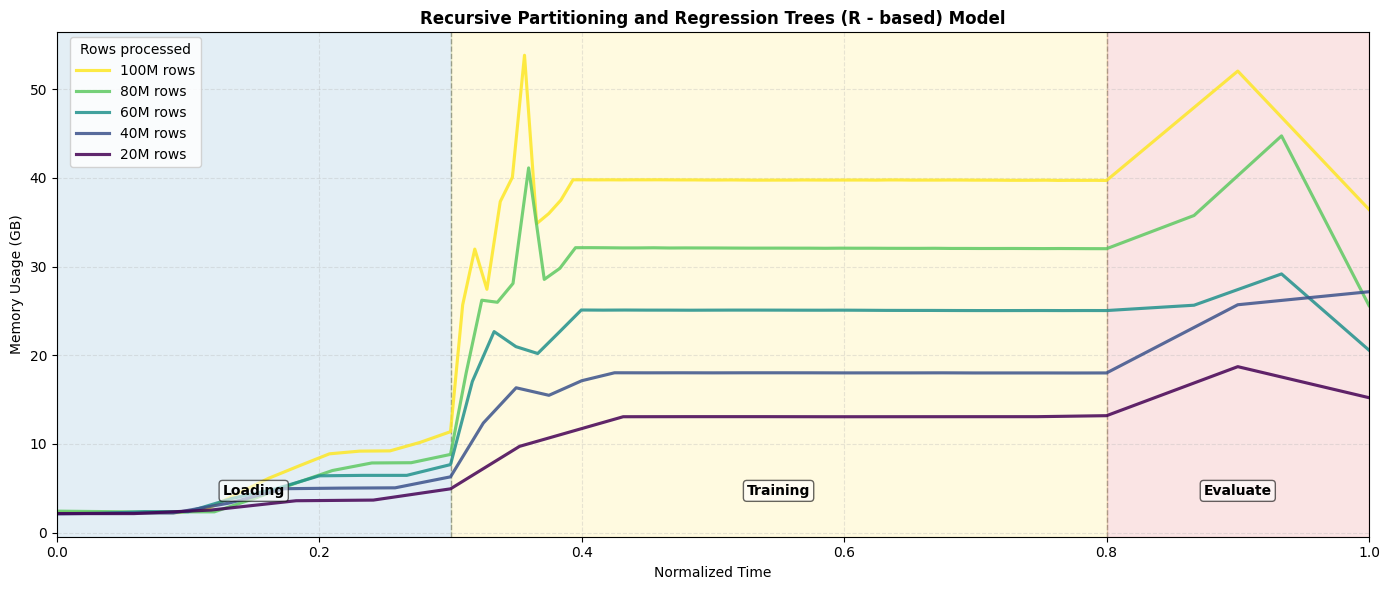

In [ ]:
# === Block 5: Super plot (overlay multiple runs on normalized axis) ===
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

RUNS_BASE = "/content/drive/MyDrive/runs"

# Segment colors and spans (must match Block 4)
SEG_COLORS = {"loading":"#1f77b4", "training":"#ffd700", "evaluate":"#d62728"}
SEG_SPANS  = {"loading":(0.00,0.30), "training":(0.30,0.80), "evaluate":(0.80,1.00)}

# Find all per-run normalized CSVs
files = sorted(glob.glob(os.path.join(RUNS_BASE, "run_*", "ram_profile_normalized.csv")))
if not files:
    raise RuntimeError("No per-run normalized CSVs found under /runs. Execute Block 4 for at least one run.")

# Optional: exact overrides if you want to force precise counts (in rows, not millions)
# Example: {"run_100m": 100_000_000, "run_80m": 80_000_000, ...}
RUN_ROWS_HINT = {}

# Load and concat
dfs = []
for fp in files:
    df = pd.read_csv(fp)
    # ensure 'run_id' exists; fallback to folder name
    run_id = df["run_id"].iloc[0] if "run_id" in df.columns else os.path.basename(os.path.dirname(fp))
    df["run_id"] = run_id
    # sanity clamps
    df = df[(df["x_global_norm"] >= 0) & (df["x_global_norm"] <= 1)]
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
unique_runs = sorted(all_df["run_id"].unique())

# Build rows_processed mapping (in absolute rows)
rows_map = {}

# 1) CSV column wins (if present)
for rid in unique_runs:
    sample = all_df[all_df["run_id"] == rid].head(1)
    if "rows_processed" in sample.columns:
        try:
            rows_map[rid] = int(sample["rows_processed"].iloc[0])
        except Exception:
            pass

# 2) User hints override
for rid, v in RUN_ROWS_HINT.items():
    rows_map[rid] = int(v)

# 3) Parse from folder/run_id like 'run_100m', 'run-80M', '100m', etc.
for rid in unique_runs:
    if rid in rows_map:
        continue
    m = re.search(r'(\d{2,3})\s*[mM]\b', rid)  # look for '##m' or '###m'
    if m:
        rows_map[rid] = int(m.group(1)) * 1_000_000

# 4) Fallback: distribute ~100M to 20M across remaining runs
missing = [rid for rid in unique_runs if rid not in rows_map]
if missing:
    n = len(unique_runs)
    approx_millions = np.linspace(100, 20, n)  # float millions across ALL runs
    approx_map = {rid: int(round(mm)) * 1_000_000 for rid, mm in zip(unique_runs, approx_millions)}
    for rid in missing:
        rows_map[rid] = approx_map[rid]

# Super plot
fig, ax = plt.subplots(figsize=(14, 6))

# Background colored bands by segment
for seg, (a,b) in SEG_SPANS.items():
    ax.axvspan(a, b, color=SEG_COLORS[seg], alpha=0.12, zorder=0)

# Vertical dashed lines at boundaries
for v in [SEG_SPANS["loading"][1], SEG_SPANS["training"][1]]:
    ax.axvline(v, color="black", linewidth=1, alpha=0.3, linestyle="--", zorder=1)

# Color runs by dataset size (bigger = darker)
min_rows = min(rows_map.values())
max_rows = max(rows_map.values())
norm = Normalize(vmin=min_rows, vmax=max_rows)
cmap = get_cmap("viridis")

# Plot each run (BOLDER LINES) with label like "100M rows"
runs_sorted = sorted(unique_runs, key=lambda r: rows_map[r], reverse=True)
for rid in runs_sorted:
    d = all_df[all_df["run_id"] == rid].sort_values("x_global_norm")
    label = f"{rows_map[rid]/1e6:.0f}M rows"
    ax.plot(
        d["x_global_norm"], d["ram_gb"],
        linewidth=2.25,          # bolder lines
        alpha=0.85,
        color=cmap(norm(rows_map[rid])),
        label=label,
        zorder=2
    )

# Bottom segment labels
y_min, y_max = all_df["ram_gb"].min(), all_df["ram_gb"].max()
y_text = y_min + 0.05 * (y_max - y_min)
for seg, (a,b) in SEG_SPANS.items():
    seg_label = "Loading" if seg=="loading" else ("Training" if seg=="training" else "Evaluate")
    x_mid = a + (b - a)/2
    ax.text(x_mid, y_text, seg_label, ha="center", va="center",
            fontsize=10, fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.6),
            zorder=3)

# Title & axes
ax.set_xlim(0, 1)
ax.set_title("Recursive Partitioning and Regression Trees (R - based) Model", fontweight="bold")
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Memory Usage (GB)")
ax.grid(True, alpha=0.3, linestyle="--")

# Legend INSIDE (top-left), replacing the old "~100M to 20M rows" header
handles, labels = ax.get_legend_handles_labels()
seen = set(); h_unique = []; l_unique = []
for h, l in zip(handles, labels):
    if l not in seen:
        h_unique.append(h); l_unique.append(l); seen.add(l)

leg = ax.legend(
    h_unique, l_unique,
    title="Rows processed",
    loc="upper left", bbox_to_anchor=(0.01, 0.99),
    frameon=True, fancybox=True, borderaxespad=0.0,
    handlelength=2.4
)
leg.get_frame().set_alpha(0.85)

plt.tight_layout()
plt.show()
